# 5. Acoustic measurements

-----

In this final notebook we'll specify some of the **parameters that are widely used in acoustical measurements, more specifically in urban noise measurements, which is the main application of the developed device**.

We will call some of the functions introduced in the previous notebooks (which are included in `utils.py`) to obtain the different parameters, and **we'll develop new functionality to be able to easily calculate sound pressure levels with the device**.

## Sound pressure level

In acoustic measurements the variable that we're interested in is the instantaneous pressure, the dynamic variations in pressure around the atmospheric pressure. This value is **defined as the logarithmic relationship between this instantaneous pressure and the hearing threshold, which is about 20 μP**.

$$ SPL = 10 \log \left( \dfrac{P_{ef}^2}{\rho_0^2} \right) \ [dB_{SPL}] $$

$$ P_{ef} = \sqrt{ \dfrac{1}{T} \int_{o}^{T} p^2 (t) \ dt } $$

As we can see, $P_{ef}$ represents the RMS value of the instantaneous pressure.

## Integrating and averaging sound level meters

Since the instantaneous SPL will vary at every instant, we normally prefer to obtain a **measurement over a certain time interval, avearing the levels**. This can be obtained by either **exponential or linear averaging of the levels**. 

As we mentioned in the previous notebook the **sound level meters traditionally provided a way to ease the reading of levels by applying an RC integrating low-pass filter to the signal**.  The application of this procedure is known as **exponential averaging** of the sound pressure levels and the type of sound level meters that perform this operation are known as **averaging meters**. The exponential component is introduced to the SPL calculation as seen below.

$$ P_\tau = \sqrt{ \dfrac{1}{\tau} \int_{0}^{t} p^2 ( \theta ) \ e ^{ - \dfrac{t-\theta}{\tau}  } \  d\theta } $$

**Three time constants are used: Slow ($\tau$ = 1 s), Fast ($\tau$ = 125 ms) and Impulse ($\tau$ = 35 ms)**.

In the thesis we developed an **integrating-averaging meter**, which means that it can also linearly integrate the levels. These allow to obtain the **equivalent-continuous sound level, $L_{eq}$**. This is, **a constant value that represents a certain soubd pressure level which for some interval _T_ has the same amount of energy than the measured signal**. Its definition is as follows:

$$ L_{eq,T} = 10 \log \dfrac{1}{T} \int_{0}^{T} \dfrac{p^2 (t) \ dt}{p_0^2} $$

In urban noise measurement the **$L_{A,eq}$** is perhaps the most widely used indicator, where the **average levels are based on the integration of A frequency-weighted levels**.

Next we will generate a random array representing **individual sound pressure levels measured at 1 s intervals for 5 minute** and we will **calculate the $L_{eq}$ for the entire period**. The calculation will be based by combining the first and last equations above (which we'll purpousefully not state because who wants to see more than three equations on a Jupyter notebook).

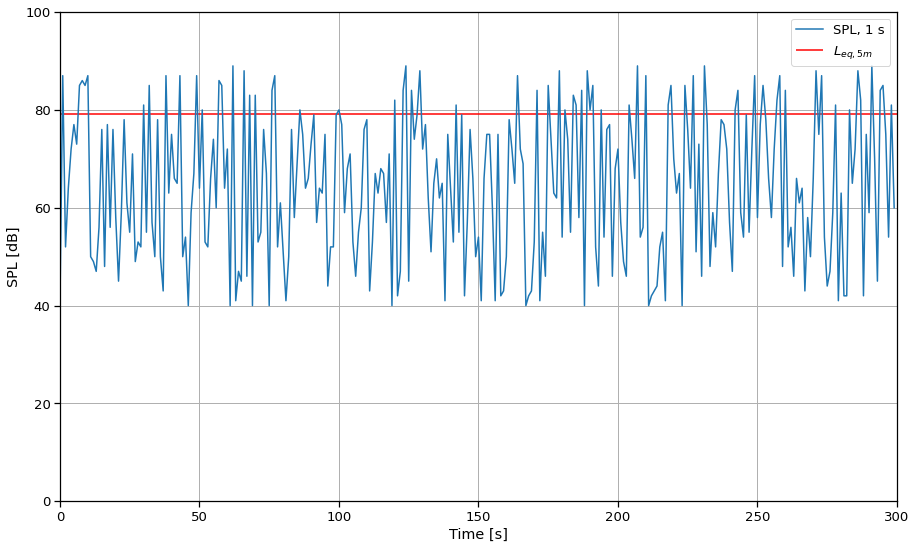

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (15,9)
sns.set_context('notebook', font_scale=1.2)

# Sampling frequency
FS = 48000

levels = np.random.randint(low=40, high=90, size=5*60)
leq = 10*np.log10(1/len(levels) * np.sum([10**(l/10) for l in levels]))

plt.plot(range(len(levels)), levels, label='SPL, 1 s')
plt.hlines(leq, 0, len(levels), color='r', label='$L_{eq, 5 m}$')

plt.xlabel('Time [s]')
plt.ylabel('SPL [dB]')
plt.xlim([0, 5*60])
plt.ylim([0, 100])
plt.legend()
plt.grid('on');

**The red line in the plot above, at the stated 5 minutes interval, has the same energy than the continuously variating SPL**. 

So, great we know what the **$L_{eq}$** represents and might have understood what makes this indicator important, easy to understand and widely used in acoustic measurements. But, how can we state this (or other) indicators with out developed device?

## Performing acoustic measurements

When doing a field measurement with a sound level meter, it is fundamental to **perform a calibration of this device agains a know acoustic source of known level and with a low uncertainty**. This is done by using **acoustic calibrators that are coupled with the microphones capsule**. Normally a level of **94 $dB_{SPL}$ or 114 $dB_{SPL}$ is used for this**.

## Getting a calibration signal for the device

In the case of our device we cant couple it directly to an acoustic calibrator because, well, there is not one designed for the type of microphone employed. For this, another method was used in which **first, we calibrated a sound level meter with its own acoustic calibrator, and then put both its capsule and our device's microphone in close proximity. We then reproduced a 1 kHz@94 $dB_{SPL}$ in an acoustic source, and recorded it with the device while measuring its equivalent level with the calibrated meter**.

Next, we'll load this recording, calculate it's RMS level and compare it to the value stated by the sound level meter during this measurement. The signal (as expected) doesn't have an exact level of 94 $dB_{SPL}$ so we need to consider the value obtained. In the code cells we'll be importing the functionality developed in the previous notebooks.

In [3]:
from sys import path
import os

path_parent = os.path.dirname(os.getcwd())
path.append(path_parent + '\\src') 

# importing from our utils module
from utils import wavread, rms

# loading the calibration recording
fs, cal_wav = wavread('../aud/cal.wav')

# Calibration Leq as stated by the sound level meter
cal_l = 94.6 # dB

# Getting the RMS level for the calibration
# we'll leave of the first and last half second
cal_rms = rms(cal_wav[int(0.5*fs):int(-0.5*fs)])

With the RMS and the sound level meter's indicated $L_{eq}$ we can now do measurements with the device!

As an example measurment we'll load the field recording and calculate the **$L_{eqA,1s}$**.

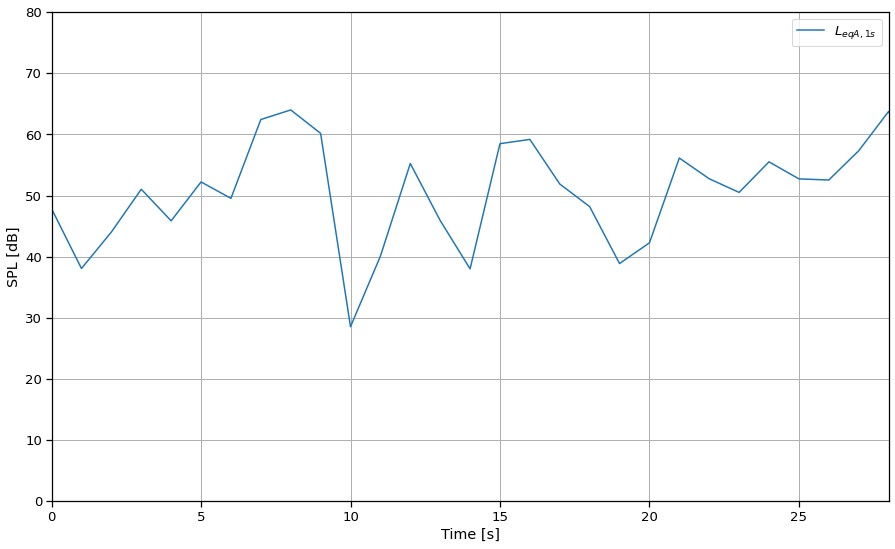

In [4]:
from utils import filt_A, rms_t

# loading
fs, field = wavread('../aud/field.wav')

# applying A-weighting filter
field_A = filt_A(field)

# getting the RMS levels per second
field_A_rms = rms_t(field_A, fs=fs)

# LeqA,1s
leqa = cal_l + 20*np.log10(field_A_rms/cal_rms)

plt.plot(range(len(leqa)), leqa, label='$L_{eqA, 1 s}$')

plt.xlabel('Time [s]')
plt.ylabel('SPL [dB]')
plt.xlim([0, 28])
plt.ylim([0, 80])
plt.legend()
plt.grid('on');

Yay! Now we can successfully measure levels by using the data from the calibration measurement. To wrap up we'll define other important parameters that have also an extended use in acoustical measurements.

## Day-evening_night noise level

The **$L_{den}$, day–evening–night noise level provides a way to express the level during the day as a single value**. It was introduced in the Directive 2002/49/CE European standard. In the equation below we can see that these parameter establishes **penalties for night and evening noise levels, for the higher annoyance it causes and the help problems associated with it.

$$ L_{den} = 10 \log \left[ \dfrac{1}{24} \ \left( 12 \cdot 10^{\dfrac{L_d}{10}} + 4 \cdot 10^\dfrac{L_e + 5}{10} + 8 \cdot 10^\dfrac{Ln + 10}{6} \right) \right]$$

## Percentile statistics

The statistical noise levels are commonly used for environmental noise monitoring, as they help to make sense of the **fluctuation of noise levels during the day**. The **$L_N$ statistical percentile is defined as the SPL value that is excedeed in a _N%_ of the measurement interval**. The higher is $N$, the lower $L_N$ gets.

The **$L_{90}$** and the **$L_{10}$** are used as a good representations of the overall **minimum and maximum values** respectively. The difference between both is know as **Noise Climate ($NC$)**, that indicates the **range of variation of the measured noise**.

In [103]:
import pandas as pd

measured_leq = pd.read_csv('../src/measured_leq.csv')

In [105]:
def join_dates(h, m, s):
    add_zero = lambda x: '0' + str(int(x)) \
        if len(str(int(x))) == 1 \
        else str(int(x))
    return add_zero(h) + ':' + \
           add_zero(m) + ':' + \
           add_zero(s)

hh_mm_ss = measured_leq.apply(lambda x: 
                              join_dates(x[0], x[1], x[2]), axis=1)

In [133]:
df = pd.concat((hh_mm_ss.apply(lambda x: datetime.strptime(x, '%H:%M:%S')\
                               .replace(year=2020, month=6, day=12)),
              measured_leq.iloc[:, -1]), axis=1)

In [134]:
df.set_index(0, inplace=True)

df.index.name = None

In [135]:
mean_db = lambda x: 10*np.log10(np.mean(10**(x/10)))

In [207]:
df_10m = df.resample('10T').apply(mean_db)

df_10m.columns = ['Leq,10m[dBA]']
df_10m.head().round(2)

,"Leq,10m[dBA]"
2020-06-12 00:00:00,59.08
2020-06-12 00:10:00,53.91
2020-06-12 00:20:00,62.31
2020-06-12 00:30:00,52.70
2020-06-12 00:40:00,53.71


In [202]:
lden_day = df.between_time('07:00', '19:00', 
                           include_end=False).apply(mean_db).values
lden_eve = df.between_time('19:00', '23:00', 
                           include_end=False).apply(mean_db).values
lden_nig = df.between_time('23:00', '07:00', 
                           include_end=False).apply(mean_db).values

lden_lden = 10*np.log10((12*(10**((lden_day)/10)) \
                         + 4*(10**((lden_eve + 5)/10)) \
                         + 8*(10**((lden_nig + 10)/10)))/24)

In [201]:
df_q = df_10m.quantile([0.1, 0.9])

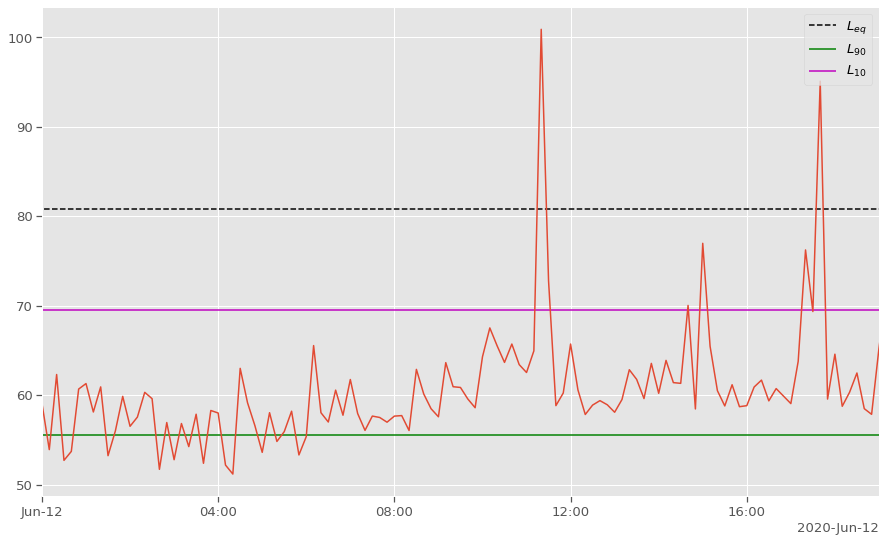

In [210]:
import matplotlib.dates as mdates
# changing plot style
plt.style.use('ggplot')

# setting locator and formatter
pd.plotting.register_matplotlib_converters()
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

fig, ax = plt.subplots()

ax.plot(df_10m)

xmin = datetime(2020, 6, 13, 0)
xmax = datetime(2020, 6, 12, 0)

ax.hlines(lden_lden, xmin, xmax, 'k', '--', label='$L_{eq}$')
ax.hlines(df_q.iloc[0], xmin, xmax, 'g', label='$L_{90}$')
ax.hlines(df_q.iloc[1], xmin, xmax, 'm', label='$L_{10}$')

ax.set_xlim([datetime(2020, 6, 12, 0), datetime(2020, 6, 12, 19)])
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.legend(loc='upper right');

## Conclusions